In [45]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

# Load Original Features

In [66]:
feat_num = 448

In [67]:
df_total = pd.read_csv('./data/features%s.csv'%(feat_num))

In [68]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [69]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [70]:
features_train.shape

(590540, 446)

# Prepare model

In [71]:
categorical = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'card_id']
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [72]:
categorical = list(set(categorical).intersection(df_total.columns))

In [73]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [74]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

# Feature Selection

In [32]:
train_set = lgb.Dataset(features_train, label=labels_train.values,
                       categorical_feature=categorical)
cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc',
                        early_stopping_rounds = 500, seed = RSEED, nfold = 5)
print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Cross Validation ROC AUC: 0.97749 with std: 0.00186.


In [33]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED,scale_pos_weight=9)
model.fit(features_train, labels_train.values)
fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance': model.feature_importances_})
fi = fi.sort_values('importance', ascending = False)

Text(0.5,1,'LGB Features (avg over folds)')

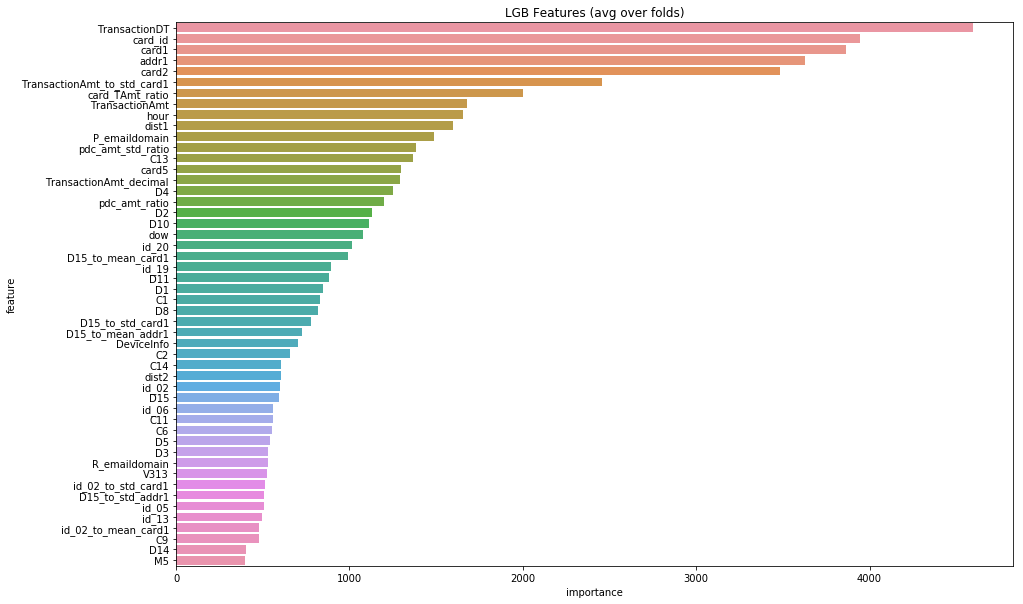

In [34]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="importance", y="feature", data=fi.iloc[0:50,:])
plt.title('LGB Features (avg over folds)')

In [75]:
fi_important = fi.iloc[0:200,:]
features_train = features_train[fi_important.feature]
features_test_new = features_test[fi_important.feature]
categorical = list(set(categorical).intersection(fi_important.feature))

# Train Model

In [76]:
splits = 5
folds = KFold(n_splits = splits,random_state=RSEED)
predictions = np.zeros(len(features_test_new))

In [77]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)

    pred = clf.predict(valid_df)
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.991976	valid_1's auc: 0.899139
[1000]	training's auc: 0.999076	valid_1's auc: 0.907204
[1500]	training's auc: 0.999927	valid_1's auc: 0.910595
[2000]	training's auc: 0.999997	valid_1's auc: 0.913017
[2500]	training's auc: 1	valid_1's auc: 0.914405
[3000]	training's auc: 1	valid_1's auc: 0.915164
[3500]	training's auc: 1	valid_1's auc: 0.915616
Early stopping, best iteration is:
[3083]	training's auc: 1	valid_1's auc: 0.915321
  auc =  0.9153214837972691
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.992667	valid_1's auc: 0.931808
[1000]	training's auc: 0.999282	valid_1's auc: 0.934038
[1500]	training's auc: 0.99996	valid_1's auc: 0.934106
Early stopping, best iteration is:
[1210]	training's auc: 0.999768	valid_1's auc: 0.934391
  auc =  0.9343912174787046
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.99301	valid_1's auc: 0.92903
[1000]	training's auc: 0.99931	valid_1's auc: 0.930345
Early stopping, best iteration is:
[884]	training's auc: 0.998781	valid_1's auc: 0.930538
  auc =  0.9305377090420976
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.992691	valid_1's auc: 0.945815
[1000]	training's auc: 0.999311	valid_1's auc: 0.948738
[1500]	training's auc: 0.999958	valid_1's auc: 0.949132
[2000]	training's auc: 0.999998	valid_1's auc: 0.949208
[2500]	training's auc: 1	valid_1's auc: 0.949121
Early stopping, best iteration is:
[2027]	training's auc: 0.999999	valid_1's auc: 0.949245
  auc =  0.9492453650122896
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.992776	valid_1's auc: 0.920728
[1000]	training's auc: 0.999274	valid_1's auc: 0.924493
[1500]	training's auc: 0.999955	valid_1's auc: 0.925242
[2000]	training's auc: 0.999999	valid_1's auc: 0.92571
[2500]	training's auc: 1	valid_1's auc: 0.925677
Early stopping, best iteration is:
[2141]	training's auc: 1	valid_1's auc: 0.925817
  auc =  0.9258166553757261


In [78]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_top200_modelselect.csv'%(feat_num), index = False)